# Traffic Sign Predictor

## Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [3]:
data_dir = './archive'
train_path = './archive/Train'
test_path = './archive/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

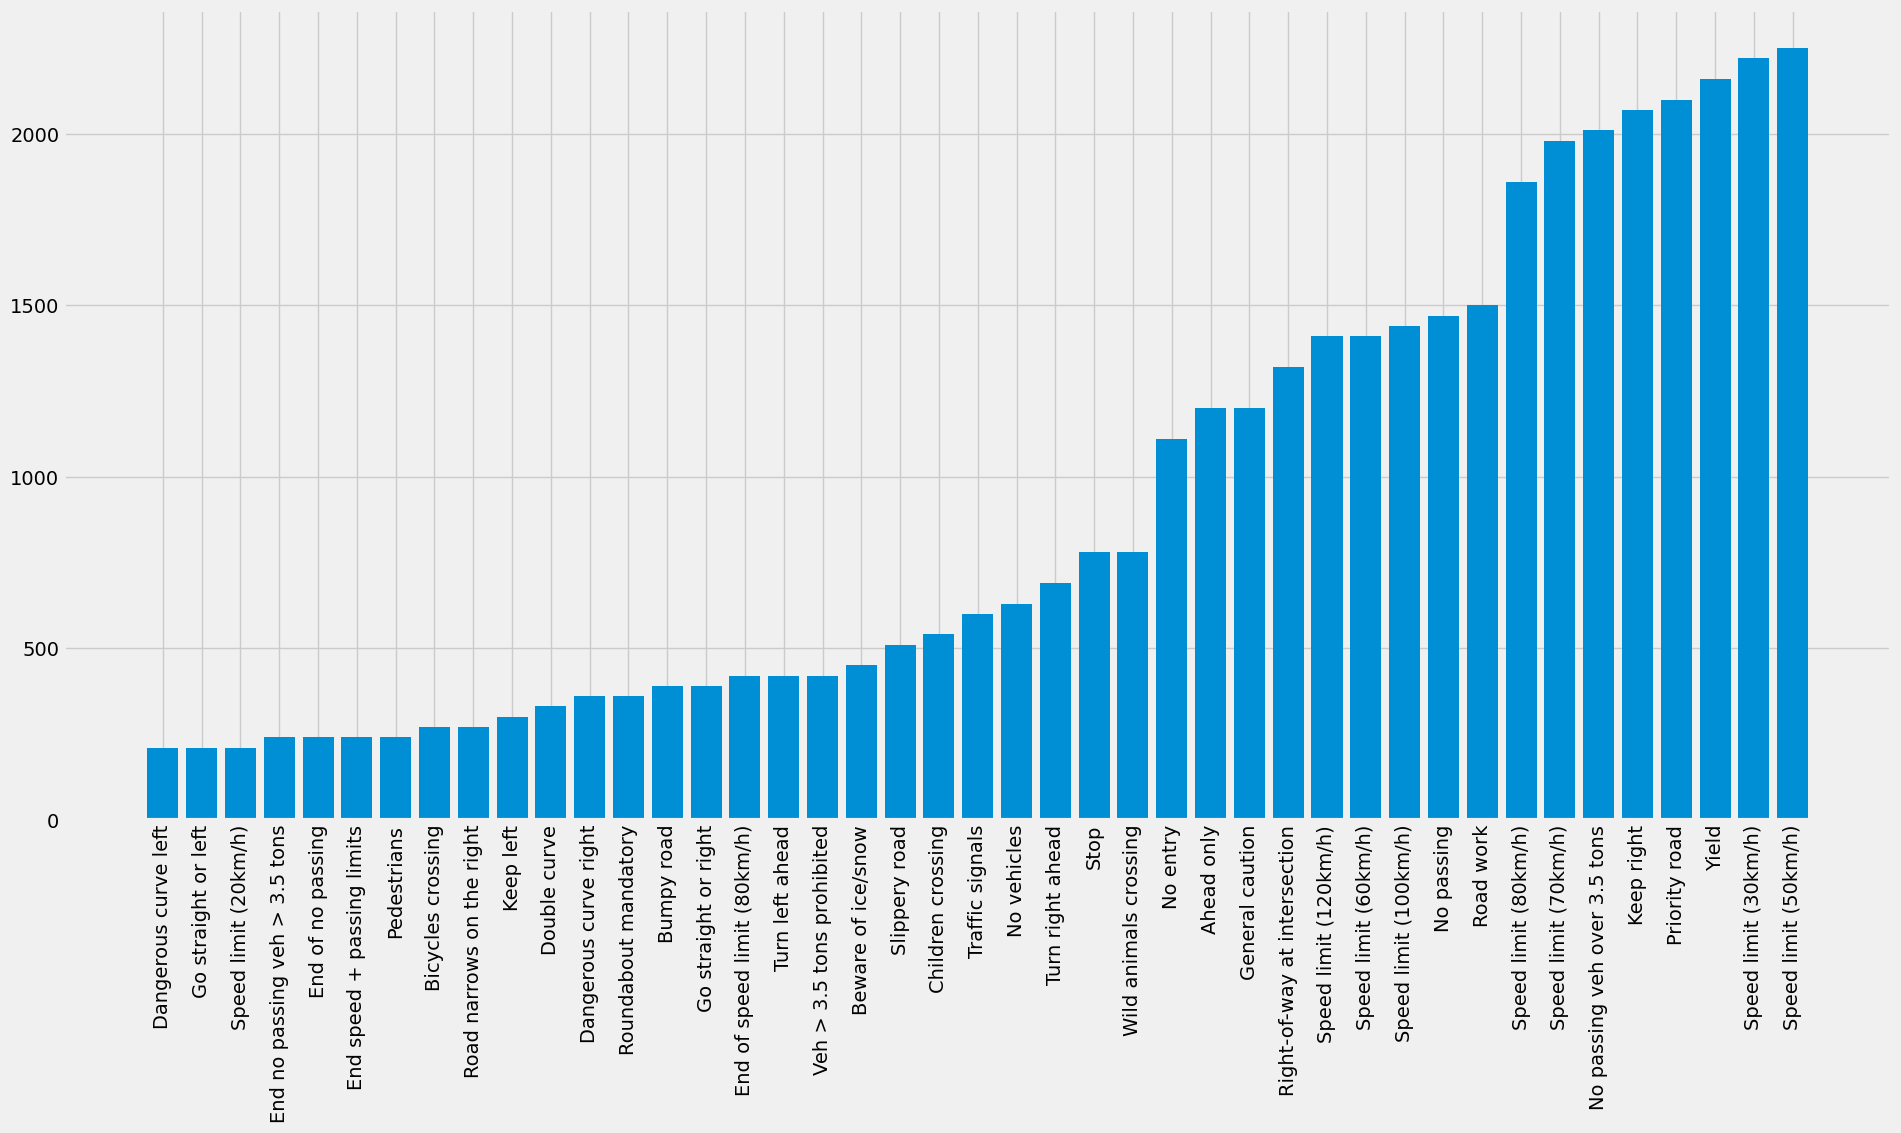

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

C:\Users\sridh\AppData\Local\Temp\ipykernel_2052\1256017970.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


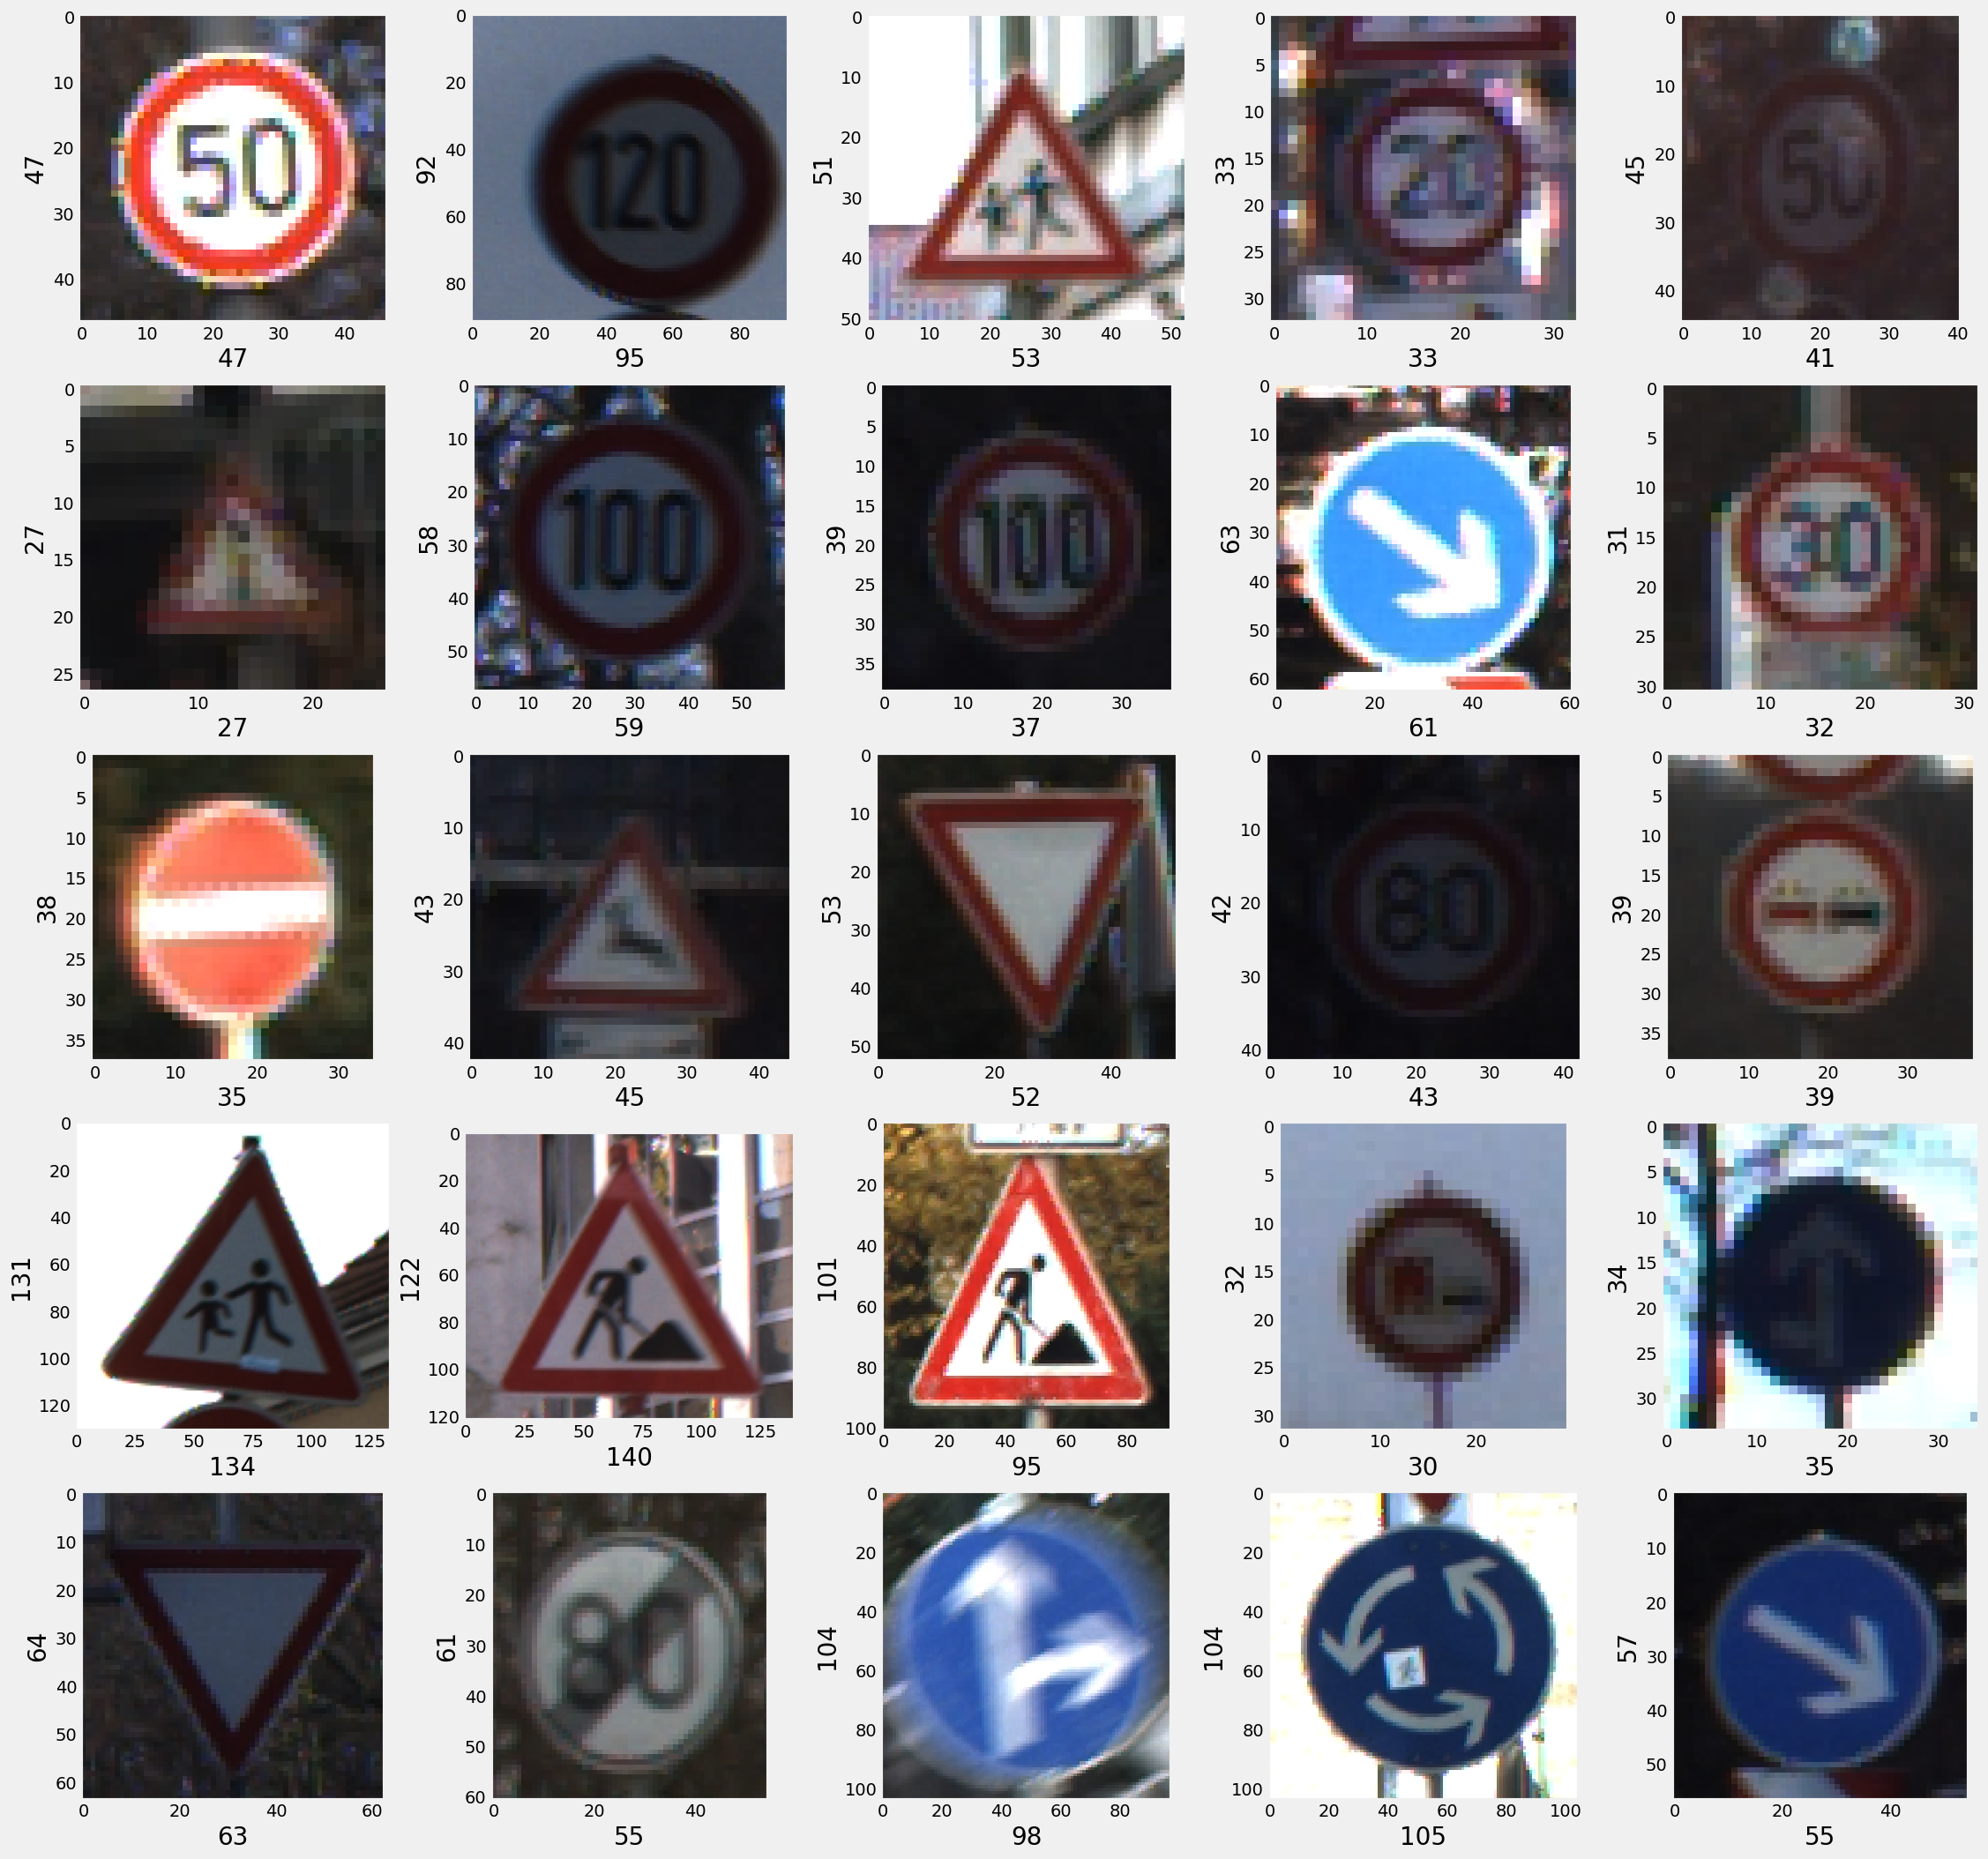

In [7]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [8]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [9]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [10]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [11]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [12]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [13]:
lr = 0.001
epochs = 30


opt = tf.keras.optimizers.legacy.Adam(lr=lr, decay=lr / (epochs * 0.5))

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

C:\Users\sridh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Augmenting the data and training the model

In [14]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 25s 28ms/step - loss: 1.0361 - accuracy: 0.7221 - val_loss: 0.0804 - val_accuracy: 0.9752
Epoch 2/30
858/858 [==============================] - 23s 27ms/step - loss: 0.1668 - accuracy: 0.9486 - val_loss: 0.0298 - val_accuracy: 0.9905
Epoch 3/30
858/858 [==============================] - 23s 27ms/step - loss: 0.1063 - accuracy: 0.9676 - val_loss: 0.0686 - val_accuracy: 0.9792
Epoch 4/30
858/858 [==============================] - 23s 26ms/step - loss: 0.0766 - accuracy: 0.9757 - val_loss: 0.0341 - val_accuracy: 0.9889
Epoch 5/30
858/858 [==============================] - 23s 27ms/step - loss: 0.0708 - accuracy: 0.9781 - val_loss: 0.0227 - val_accuracy: 0.9929
Epoch 6/30
858/858 [==============================] - 23s 26ms/step - loss: 0.0578 - accuracy: 0.9825 - val_loss: 0.0138 - val_accuracy: 0.9957
Epoch 7/30
858/858 [==============================] - 22s 26ms/step - loss: 0.0404 - accuracy: 0.9875 - val_loss: 0.0121 - val_accuracy:

## Evaluating the model

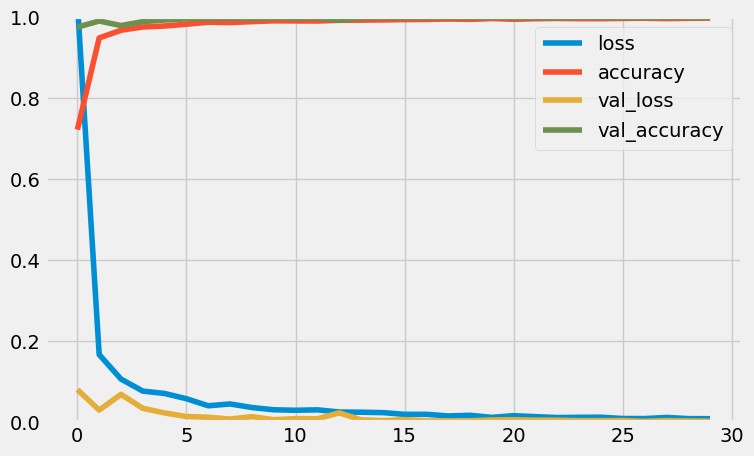

In [15]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [16]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255
# Assuming model.predict returns probabilities for each class
pred_probs = model.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)

# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred_classes) * 100)

# pred = model.predict_classes(X_test)

# #Accuracy with the test data
# print('Test Data accuracy: ',accuracy_score(labels, pred)*100)


395/395 [==============================] - 2s 6ms/step
Test Data accuracy:  98.86777513855898


## Visualizing the confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred_classes)

<AxesSubplot: >

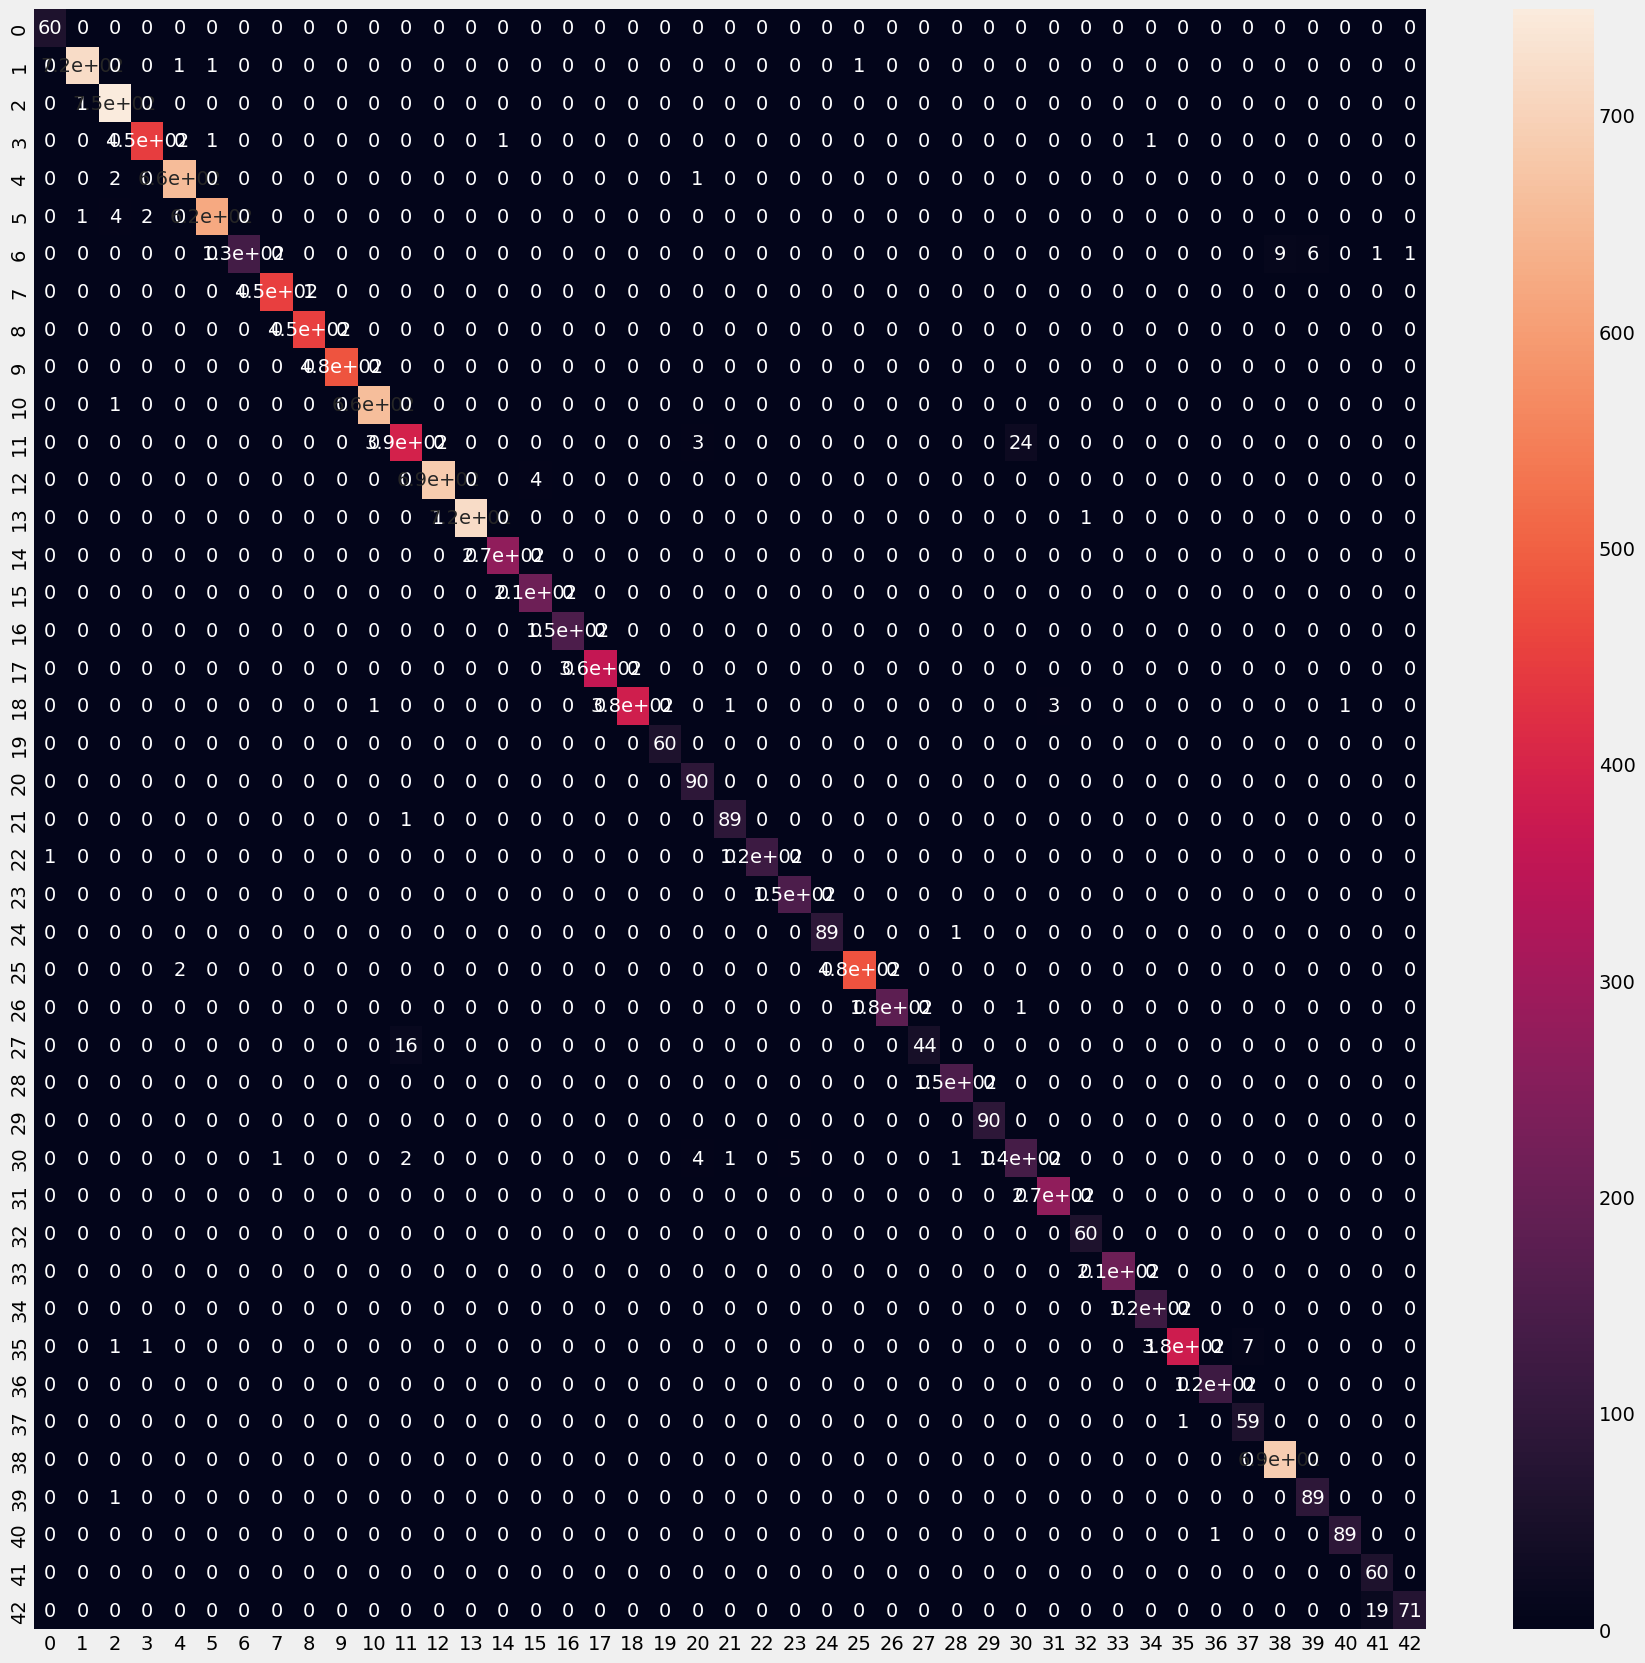

In [18]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [19]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred_classes))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       0.99      0.99      0.99       450
           4       1.00      1.00      1.00       660
           5       1.00      0.99      0.99       630
           6       1.00      0.89      0.94       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.95      0.94      0.94       420
          12       1.00      0.99      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predictions on Test Data

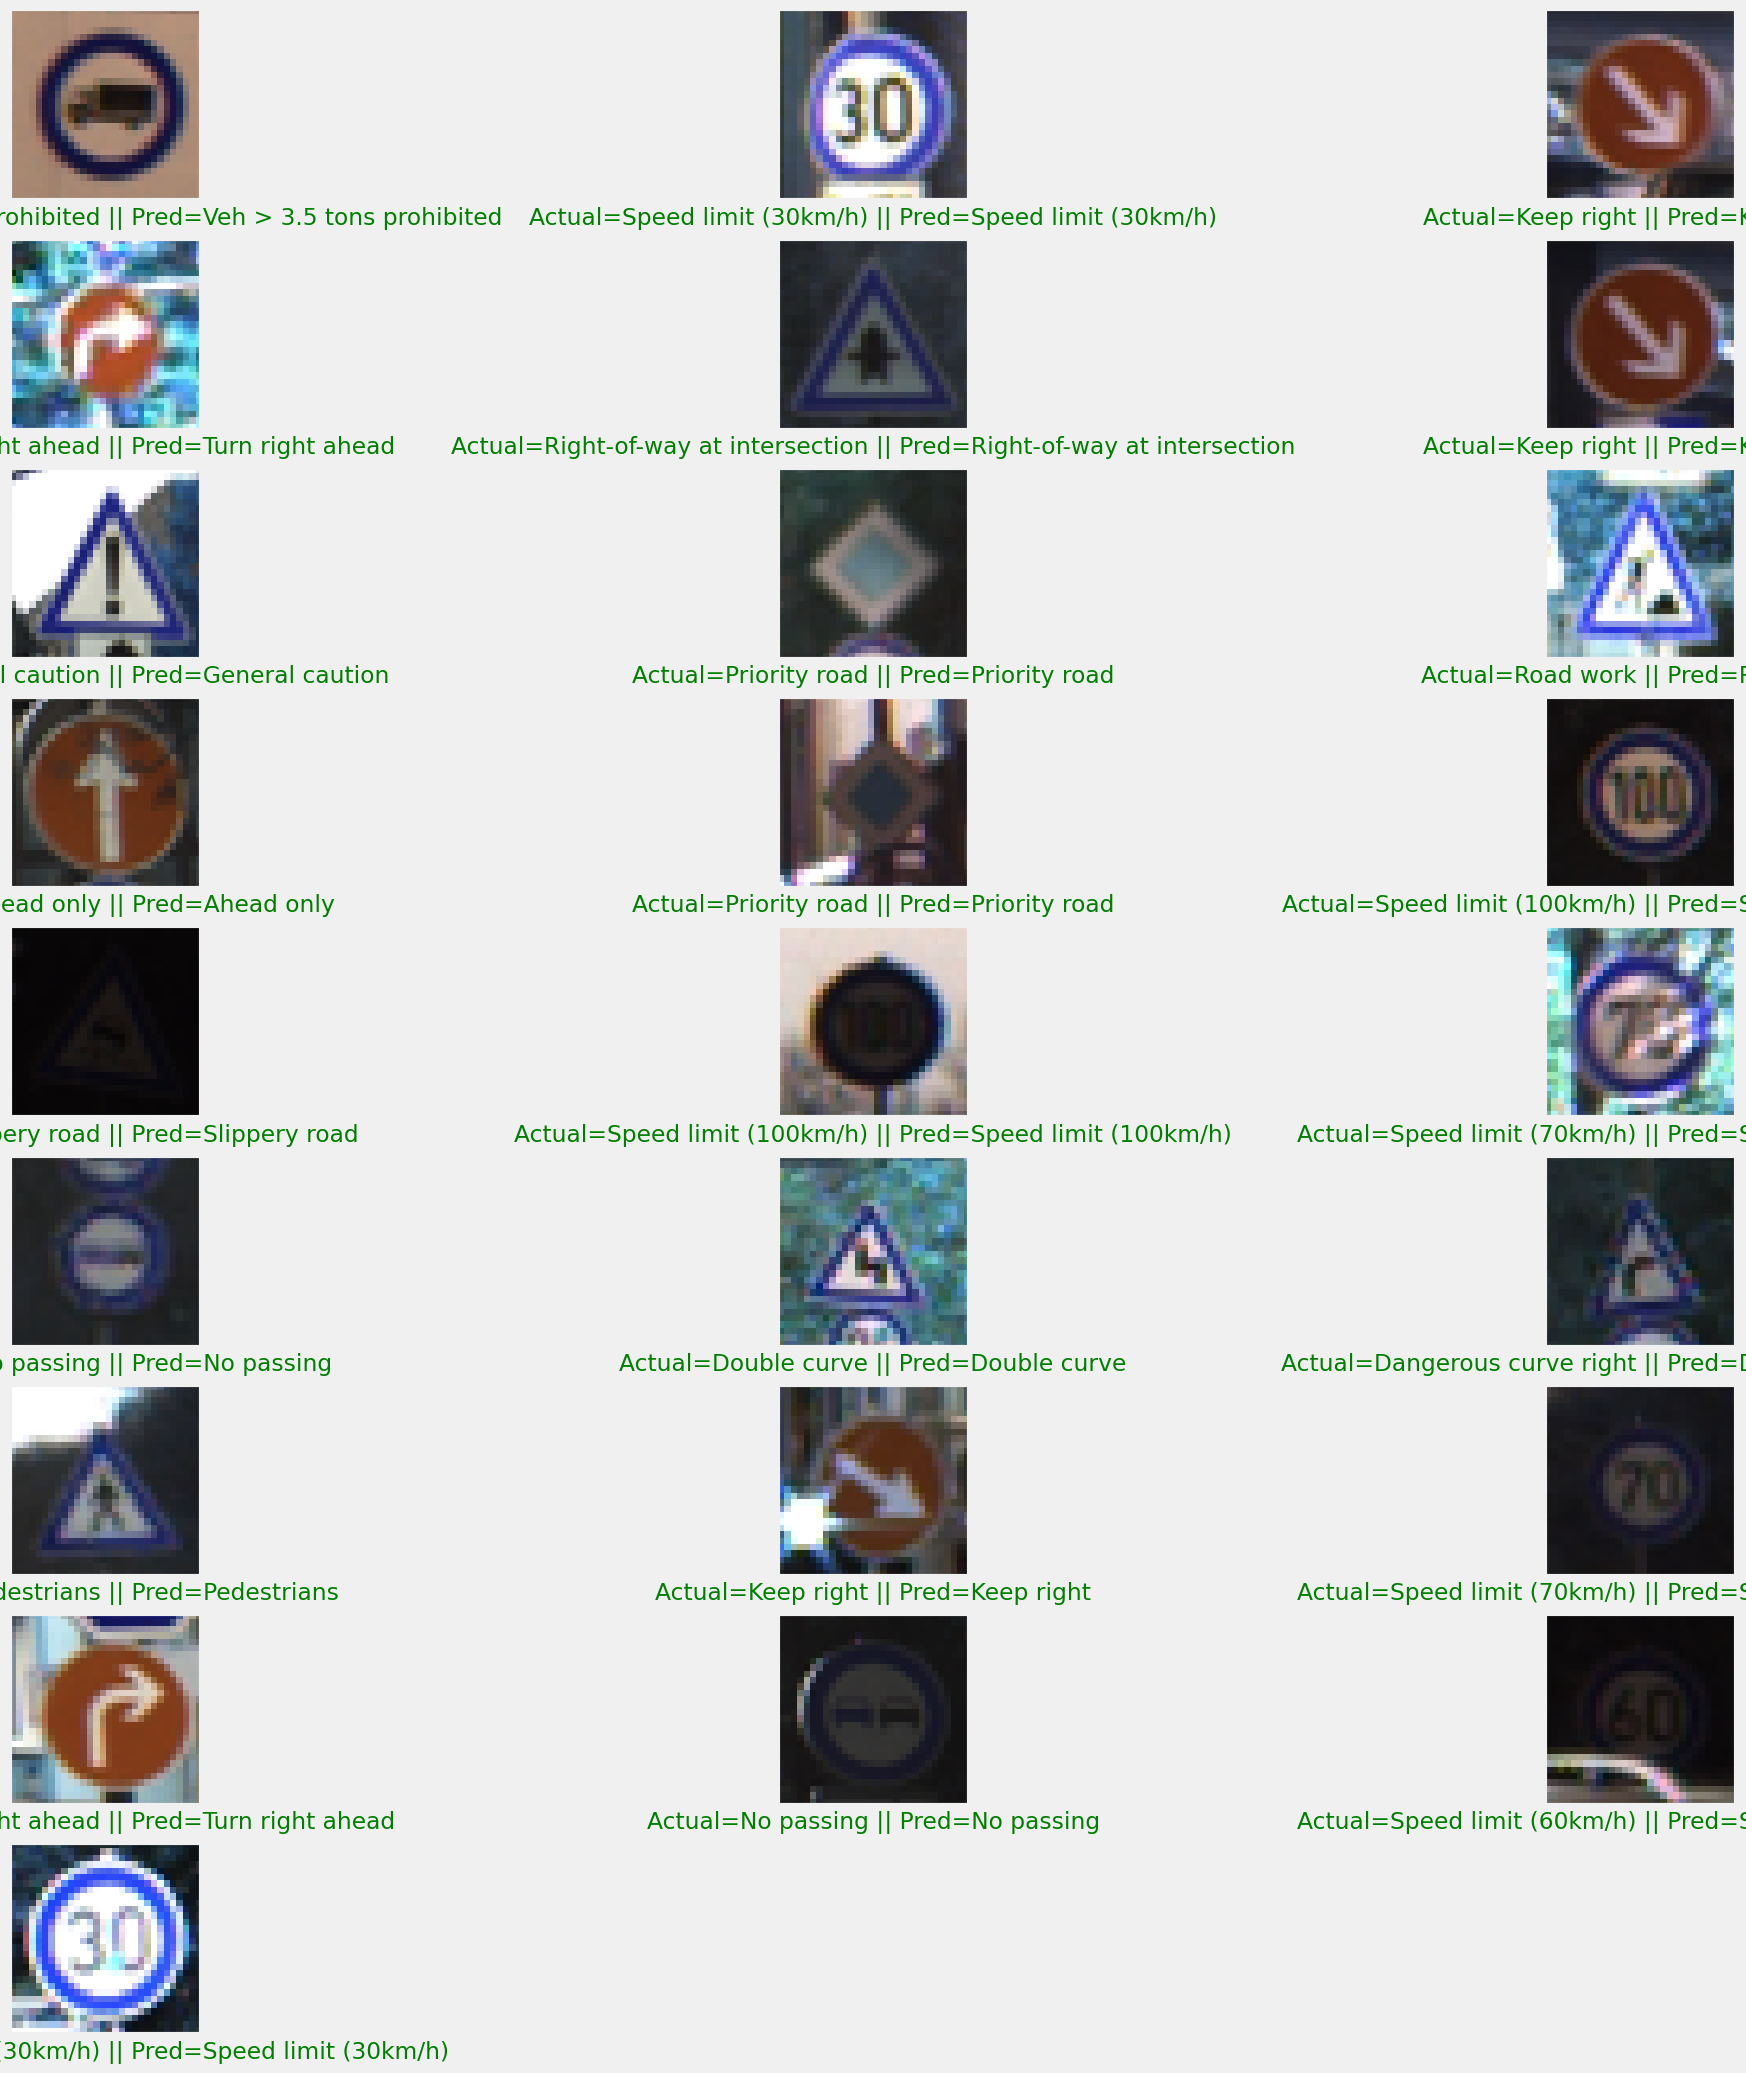

In [20]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(9, 3, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_classes[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    prediction_name = classes[prediction]
    actual_name = classes[actual]
    plt.xlabel('Actual={} || Pred={}'.format(actual_name, prediction_name), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 13, 13, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         7